In [101]:
import pandas as pd

In [102]:
df = pd.read_csv('final_dataframe.csv',index_col=0)

In [41]:
df.head()

,ISBN,title,series,author,rating,genre,publish_date,publish_company,format,number_of_pages,publish_month,publish_year,NYT_bestseller,length_of_title,num_words_in_title,top_authors
0,9781419726552,"F*ck, That's Delicious: An Annotated Guide to ...",0,Action Bronson,4.17,food-and-drink,September 12th 2017,Harry N. Abrams,Hardcover,192,September,2017,1.0,57,9,0
1,9780982301821,10-Day Green Smoothie Cleanse: Lose Up to 15 P...,0,J.J. Smith,4.11,health,February 9th 2014,Adiva Publishing,Paperback,167,February,2014,1.0,63,12,0
2,9780316407076,15th Affair,1,James Patterson,4.09,mystery,May 2nd 2016,Hachette,Hardcover,351,May,2016,1.0,11,2,1
3,9780718088804,42 Faith: The Rest of the Jackie Robinson Story,0,Ed Henry,4.16,biography,April 4th 2017,Harper Collins,Hardcover,368,April,2017,1.0,47,9,0
4,9780451495426,7 Lessons from Heaven: How Dying Taught Me to ...,0,Mary C. Neal,4.08,non-fiction,September 19th 2017,Convergent Books,Paperback,288,September,2017,1.0,68,13,0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1646 entries, 0 to 1670
Data columns (total 16 columns):
ISBN                  1646 non-null int64
title                 1646 non-null object
series                1646 non-null int64
author                1646 non-null object
rating                1646 non-null float64
genre                 1646 non-null object
publish_date          1645 non-null object
publish_company       1637 non-null object
format                1645 non-null object
number_of_pages       1646 non-null int64
publish_month         1646 non-null object
publish_year          1646 non-null int64
NYT_bestseller        1646 non-null float64
length_of_title       1646 non-null int64
num_words_in_title    1646 non-null int64
top_authors           1646 non-null int64
dtypes: float64(2), int64(7), object(7)
memory usage: 218.6+ KB


# Set up for modeling

In [103]:
# train, test, split
from sklearn.model_selection import train_test_split

In [104]:
feats = ['series','rating','publish_month','length_of_title',
         'publish_company','genre','num_words_in_title','top_authors']

X = pd.get_dummies(df[feats], drop_first=True)

In [105]:
# for publisher, genre, and month of publishing, i only want the "important ones"
# which i have deemed to be anything where the count was over 10 

X.drop([col for col, val in X.sum().iteritems() if val < 10], axis=1, inplace=True)

In [106]:
X.columns

Index(['series', 'rating', 'length_of_title', 'num_words_in_title',
       'top_authors', 'publish_month_August', 'publish_month_December',
       'publish_month_February', 'publish_month_January', 'publish_month_July',
       'publish_month_June', 'publish_month_March', 'publish_month_May',
       'publish_month_November', 'publish_month_October',
       'publish_month_September', 'publish_company_Hachette',
       'publish_company_Harper Collins',
       'publish_company_Houghton Mifflin Harcourt',
       'publish_company_Macmillan', 'publish_company_Penguin Random House',
       'publish_company_Simon & Schuster', 'genre_autobiography',
       'genre_biography', 'genre_childrens', 'genre_contemporary',
       'genre_fantasy', 'genre_fiction', 'genre_food-and-drink',
       'genre_historical', 'genre_history', 'genre_horror',
       'genre_media-tie-in', 'genre_mystery', 'genre_non-fiction',
       'genre_poetry', 'genre_politics', 'genre_romance',
       'genre_science-fiction', 'ge

In [107]:
# Y is the target variable
Y = df['NYT_bestseller']

In [108]:
X.head()

,series,rating,length_of_title,num_words_in_title,top_authors,publish_month_August,publish_month_December,publish_month_February,publish_month_January,publish_month_July,...,genre_non-fiction,genre_poetry,genre_politics,genre_romance,genre_science-fiction,genre_sequential-art,genre_short-stories,genre_sports-and-games,genre_thriller,genre_young-adult
0,0,4.17,57,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4.11,63,12,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4.09,11,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4.16,47,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,4.08,68,13,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [109]:
# normalize the features

for col in X.columns:
    X[col] = (X[col]-min(X[col]))/ (max(X[col]) - min(X[col])) 

#We subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature

X.head()

,series,rating,length_of_title,num_words_in_title,top_authors,publish_month_August,publish_month_December,publish_month_February,publish_month_January,publish_month_July,...,genre_non-fiction,genre_poetry,genre_politics,genre_romance,genre_science-fiction,genre_sequential-art,genre_short-stories,genre_sports-and-games,genre_thriller,genre_young-adult
0,0.0,0.624434,0.295082,0.235294,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.597285,0.327869,0.323529,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.588235,0.043716,0.029412,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.619910,0.240437,0.235294,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.583710,0.355191,0.352941,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

# Baseline: 

In [116]:
df['NYT_bestseller'].value_counts(normalize=True)

0.0    0.665249
1.0    0.334751
Name: NYT_bestseller, dtype: float64

In [ ]:
# i need my model to perform better than guessing not best seller every time! (aka 67%)

# Model 1: Logistic Regression

In [78]:
from sklearn.linear_model import LogisticRegression

In [123]:
logreg = LogisticRegression(fit_intercept = False, C = 1, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# Inverse regularization parameter - A control variable that retains strength 
# modification of Regularization by being inversely positioned to the Lambda regulator.

# high C = overfit, low C= underfit
# want a C value that minimizes the difference b/w train and test accuracy


# C = 1/λ

In [124]:
# y_hat predicted values
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

### Evaluate

In [140]:
import numpy as np
#We could subtract the two columns. If values or equal, difference will be zero. Then count number of zeros.
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())

# higher error for non-bestsellers 

print(pd.Series(residuals).value_counts(normalize=True))

0.0    976
1.0    340
Name: NYT_bestseller, dtype: int64
0.0    0.741641
1.0    0.258359
Name: NYT_bestseller, dtype: float64


In [126]:
# diff in error seems to be about 3% b/w train and test - lets play with C parameter to improve this
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0.0    236
1.0     94
Name: NYT_bestseller, dtype: int64
0.0    0.715152
1.0    0.284848
Name: NYT_bestseller, dtype: float64


In [127]:
# model was ~ 74% accurate for training data, and about 72% for our test data

In [128]:
# run a confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)

In [129]:
print(cnf_matrix)

[[201  28]
 [ 66  35]]


In [130]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.87772926 0.12227074]
 [0.65346535 0.34653465]]


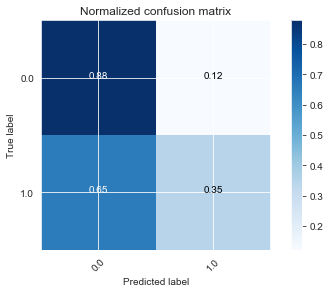

In [131]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# 'TP', 'TN', 'FP', 'FN'
# TP = 35%
# TN = 88%
# FP = 12%
# FN = 65%


$Precision = \frac{\text{Number of True Positives}}{\text{Number of Predicted Positives}}$    
  

$Recall = \frac{\text{Number of True Positives}}{\text{Number of Actual Total Positives}}$  
  
$Accuracy = \frac{\text{Number of True Positives + True Negatives}}{\text{Total Observations}}$

$\text{F1-Score} = 2\ \frac{Precision\ x\ Recall}{Precision + Recall}$


In [95]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [141]:
# number of books the model correctly classified as bestsellers divided by
# total number of books the model classified as best sellers

print(precision_score(y_hat_train, y_train))
print(precision_score(y_hat_test, y_test))

0.4533333333333333
0.3465346534653465


In [142]:
# number of books the model correctly classified as bestsellers divided by
# the actual number of bestsellers in the data set

print(recall_score(y_hat_train, y_train))
print(recall_score(y_hat_test, y_test))

0.6845637583892618
0.5555555555555556


In [134]:
# things the model classified correctly - this means we are about 9% better than just guessing the 
# negative class for all observations!
print(accuracy_score(y_hat_train, y_train))
print(accuracy_score(y_hat_test, y_test))

0.7416413373860182
0.7151515151515152


In [135]:
# hybrid
print(f1_score(y_hat_train, y_train))
print(f1_score(y_hat_test, y_test))

0.5454545454545455
0.4268292682926829


In [111]:
## ROC and AUC
from sklearn.metrics import roc_curve, auc

In [136]:
y_score = logreg.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

AUC: 0.7376886160231744


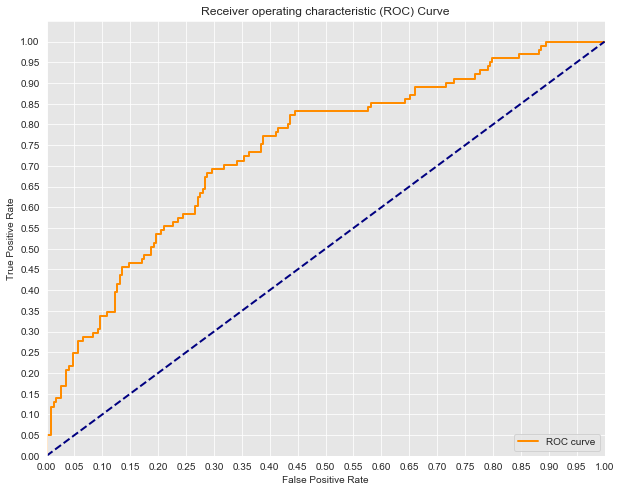

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# The Receiver Operator Characteristic curve (ROC curve) which 
# illustrates the true positive rate against false positive rate of our classifier.

# Model 2: KNN

In [149]:
from sklearn.neighbors import KNeighborsClassifier
clf1 = KNeighborsClassifier()
clf1.fit(X_train, y_train)
y_hat_test = clf1.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [151]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    
print_metrics(y_test, y_hat_test)

Precision Score: 0.5211267605633803
Recall Score: 0.36633663366336633
Accuracy Score: 0.703030303030303
F1 Score: 0.4302325581395348


In [ ]:
# this model was better in :
    # precision score (log reg was 34%)
    # f1 (log reg was 42%)

# this model was worse in :
    # recall score (log reg was 55%)
    # accuracy score (log reg was 72%)

In [152]:
from sklearn.model_selection import GridSearchCV

In [164]:
params = {'n_neighbors': [1,3,5,7,9,11,13],
          'weights':['uniform','distance'],
          'metric':['euclidean','manhattan']}
gs=GridSearchCV(clf1,params,n_jobs=-1, verbose=1, cv=3)
gs_results= gs.fit(X_train,y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:    3.4s finished


In [165]:
gs_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}

In [166]:
gs_results.best_score_

0.7127659574468085

In [167]:
gs_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=None, n_neighbors=13, p=2,
           weights='uniform')

In [ ]:
# - weights which can be set to either ‘uniform’, where each neighbor 
# within the boundary carries the same weight or ‘distance’ where closer 
# points will be more heavily weighted toward the decision. 
# Note that when weights = 'distance' the class with the highest number in the boundary may not “win the vote”